In [12]:
import numpy as np
from utils.slam_helpers import transform_to_frame,transformed_params2depthplussilhouette,transformed_params2rendervar,transformed_GRNparams2rendervar,transformed_GRNparams2depthplussilhouette
from diff_gaussian_rasterization import GaussianRasterizer as Renderer
from scripts.main_SurgeSplat import deform_gaussians, setup_camera
import torch
import os
from PIL import Image

In [13]:
intrinsics = torch.tensor([[199.6883,   0.0000, 166.3290],
        [  0.0000, 249.4753, 170.4058],
        [  0.0000,   0.0000,   1.0000]], device='cuda:0')
w2c = torch.tensor([[ 1.0000e+00,  6.5711e-11,  2.3283e-10,  0.0000e+00],
        [-3.1832e-11,  1.0000e+00, -7.4115e-21,  0.0000e+00],
        [-9.2644e-22,  2.9104e-11,  1.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]], device='cuda:0')

cam = setup_camera(336,336, intrinsics.cpu().numpy(), w2c.detach().cpu().numpy(), use_simplification=True)




In [14]:
params_np = np.load('/media/thesis_ssd/code/EndoGSLAM/EndoGSLAM/experiments/EndoNerf cutting_deform_short_simple/cutting_deform_short_simple/params.npz')
params={}
for key in params_np.keys():
    params[key] = torch.tensor(params_np[key]).cuda()

In [15]:
params

{'means3D': tensor([[[-0.8277, -0.8277, -0.8277,  ..., -0.8277, -0.8277, -0.8277],
          [-0.6788, -0.6788, -0.6788,  ..., -0.6788, -0.6788, -0.6788],
          [ 0.9937,  0.9937,  0.9937,  ...,  0.9937,  0.9937,  0.9937]],
 
         [[-0.8221, -0.8221, -0.8221,  ..., -0.8221, -0.8221, -0.8221],
          [-0.6782, -0.6782, -0.6782,  ..., -0.6782, -0.6782, -0.6782],
          [ 0.9929,  0.9929,  0.9929,  ...,  0.9929,  0.9929,  0.9929]],
 
         [[-0.8170, -0.8170, -0.8170,  ..., -0.8170, -0.8170, -0.8170],
          [-0.6781, -0.6781, -0.6781,  ..., -0.6781, -0.6781, -0.6781],
          [ 0.9928,  0.9928,  0.9928,  ...,  0.9928,  0.9928,  0.9928]],
 
         ...,
 
         [[-0.2664, -0.2664, -0.2664,  ..., -0.2664, -0.2664, -0.2664],
          [ 0.3438,  0.3438,  0.3438,  ...,  0.3438,  0.3438,  0.3438],
          [ 0.5389,  0.5389,  0.5389,  ...,  0.5389,  0.5389,  0.5389]],
 
         [[-0.3470, -0.3470, -0.3470,  ..., -0.3470, -0.3470, -0.3470],
          [ 0.3176,  0.31

In [16]:

# def deform_gaussians(params,time,deform_grad):

#     if deform_grad:
#         weights = params['deform_weights']
#         stds = params['deform_stds']
#         biases = params['deform_biases']
#     else:
#         weights = params['deform_weights'].detach()
#         stds = params['deform_stds'].detach()
#         biases = params['deform_biases'].detach()

#     deform = torch.sum(weights*torch.exp(-1/(2*stds**2)*(time-biases)**2),1) # Nx10 gaussians deformations
#     deform_xyz = deform[:,:3]
#     deform_rots = deform[:,3:7]
#     deform_scales = deform[:,7:10]
#     # print(f'xyz: {torch.sum(deform_xyz)}')
#     # print(torch.sum(deform_rots).item())
#     # print(torch.sum(deform_scales).item())
#     xyz = params['means3D']+deform_xyz
#     rots = params['unnorm_rotations']+deform_rots
#     scales = params['log_scales']+deform_scales

#     return xyz,rots,scales


# def deform_gaussians(params, time, deform_grad, N=5):
#     """
#     Calculate deformations using the N closest basis functions based on |time - bias|.

#     Args:
#         params (dict): Dictionary containing deformation parameters.
#         time (torch.Tensor): Current time step.
#         deform_grad (bool): Whether to calculate gradients for deformations.
#         N (int): Number of closest basis functions to consider.

#     Returns:
#         xyz (torch.Tensor): Updated 3D positions.
#         rots (torch.Tensor): Updated rotations.
#         scales (torch.Tensor): Updated scales.
#     """
#     if deform_grad:
#         weights = params['deform_weights']
#         stds = params['deform_stds']
#         biases = params['deform_biases']
#     else:
#         weights = params['deform_weights'].detach()
#         stds = params['deform_stds'].detach()
#         biases = params['deform_biases'].detach()

#     # Calculate the absolute difference between time and biases
#     time_diff = torch.abs(time - biases)

#     # Get the indices of the N smallest time differences
#     _, top_indices = torch.topk(-time_diff, N, dim=1)  # Negative for smallest values

#     # Create a mask to select only the top N basis functions
#     mask = torch.zeros_like(time_diff, dtype=torch.float)
#     mask.scatter_(1, top_indices, 1.0)

#     # Apply the mask to weights and biases
#     masked_weights = weights * mask
#     masked_biases = biases * mask

#     # Calculate deformations
#     deform = torch.sum(
#         masked_weights * torch.exp(-1 / (2 * stds**2) * (time - masked_biases)**2), dim=1
#     )  # Nx10 gaussians deformations

#     deform_xyz = deform[:, :3]
#     deform_rots = deform[:, 3:7]
#     deform_scales = deform[:, 7:10]

#     xyz = params['means3D'] + deform_xyz
#     rots = params['unnorm_rotations'] + deform_rots
#     scales = params['log_scales'] + deform_scales

#     return xyz, rots, scales

def deform_gaussians(params, time, deform_grad, N=5,deformation_type = 'gaussian'):
    """
    Calculate deformations using the N closest basis functions based on |time - bias|.

    Args:
        params (dict): Dictionary containing deformation parameters.
        time (torch.Tensor): Current time step.
        deform_grad (bool): Whether to calculate gradients for deformations.
        N (int): Number of closest basis functions to consider.

    Returns:
        xyz (torch.Tensor): Updated 3D positions.
        rots (torch.Tensor): Updated rotations.
        scales (torch.Tensor): Updated scales.
    """
    if deformation_type =='gaussian':
        if deform_grad:
            weights = params['deform_weights']
            stds = params['deform_stds']
            biases = params['deform_biases']
        else:
            weights = params['deform_weights'].detach()
            stds = params['deform_stds'].detach()
            biases = params['deform_biases'].detach()

        # Calculate the absolute difference between time and biases
        time_diff = torch.abs(time - biases)

        # Get the indices of the N smallest time differences
        _, top_indices = torch.topk(-time_diff, N, dim=1)  # Negative for smallest values

        # Create a mask to select only the top N basis functions
        mask = torch.zeros_like(time_diff, dtype=torch.float)
        mask.scatter_(1, top_indices, 1.0).detach()

        # Register a gradient hook to zero out gradients for irrelevant basis functions
        if deform_grad:
            def zero_out_irrelevant_gradients(grad):
                return grad * mask

            weights.register_hook(zero_out_irrelevant_gradients)
            biases.register_hook(zero_out_irrelevant_gradients)
            stds.register_hook(zero_out_irrelevant_gradients)

        # Calculate deformations
        deform = torch.sum(
            weights * torch.exp(-1 / (2 * stds**2) * (time - biases)**2), dim=1
        )  # Nx10 gaussians deformations

        deform_xyz = deform[:, :3]
        deform_rots = deform[:, 3:7]
        deform_scales = deform[:, 7:10]

        xyz = params['means3D'] + deform_xyz
        rots = params['unnorm_rotations'] + deform_rots
        scales = params['log_scales'] + deform_scales


    elif deformation_type == 'simple':
        with torch.no_grad():
            xyz = params['means3D'][...,time]
            rots = params['unnorm_rotations'][...,time]
            scales = params['log_scales'][...,time]

    return xyz, rots, scales

for id in range(params['cam_unnorm_rots'].shape[-1]):
    local_means,local_rots,local_scales = deform_gaussians(params,id,deform_grad = True,deformation_type='simple')


    #  print(torch.sum(local_means-params['means3D']))

    transformed_pts = transform_to_frame(local_means,params,id,False,False)





    # Initialize Render Variables
    rendervar = transformed_GRNparams2rendervar(params, transformed_pts,local_rots,local_scales)
    print(local_scales.max())
    rv_store = {}
    for key in rendervar.keys():
        rv_store[key] = rendervar[key].cpu().detach()
        local_means_store = local_means.cpu()
        local_scales_store = local_rots.cpu()
        local_rots_store = local_rots.cpu()
        transformed_pts_store = transformed_pts.cpu()



    #  rendervar['means3D'].retain_grad()
    depth_sil_rendervar = transformed_GRNparams2depthplussilhouette(params, w2c,
                                            transformed_pts,local_rots,local_scales)


    #RGB Rendering

    rendervar['means2D'].retain_grad()
    im, radius, _ = Renderer(raster_settings=cam)(**rendervar)
    # variables['means2D'] = rendervar['means2D'] # Gradient only accum from colour render for densification
    img = Image.fromarray((im.permute(1,2,0).cpu().detach().numpy()*255).astype(np.uint8))
    os.makedirs(f'./eval_plots/plots_simple/',exist_ok=True)
    img.save(f'./eval_plots/plots_simple/{id}.png')

    print(local_means)


tensor(2.2169e-05, device='cuda:0')
tensor([[-0.8277, -0.6788,  0.9937],
        [-0.8221, -0.6782,  0.9929],
        [-0.8170, -0.6781,  0.9928],
        ...,
        [-0.2664,  0.3438,  0.5389],
        [-0.3470,  0.3176,  0.4874],
        [-0.3298,  0.3274,  0.5030]], device='cuda:0')
tensor(2.2169e-05, device='cuda:0')
tensor([[-0.8277, -0.6788,  0.9937],
        [-0.8221, -0.6782,  0.9929],
        [-0.8170, -0.6781,  0.9928],
        ...,
        [-0.2664,  0.3438,  0.5389],
        [-0.3470,  0.3176,  0.4874],
        [-0.3298,  0.3274,  0.5030]], device='cuda:0')
tensor(2.2169e-05, device='cuda:0')
tensor([[-0.8277, -0.6788,  0.9937],
        [-0.8221, -0.6782,  0.9929],
        [-0.8170, -0.6781,  0.9928],
        ...,
        [-0.2664,  0.3438,  0.5389],
        [-0.3470,  0.3176,  0.4874],
        [-0.3298,  0.3274,  0.5030]], device='cuda:0')
tensor(2.2169e-05, device='cuda:0')
tensor([[-0.8277, -0.6788,  0.9937],
        [-0.8221, -0.6782,  0.9929],
        [-0.8170, -0.67

In [6]:
params['cam_trans']

tensor([[[ 0.0000e+00,  2.1391e-03, -3.1054e-03, -1.3241e-02, -3.4979e-02,
          -5.7853e-02, -6.2729e-02, -6.2194e-02, -5.3233e-02, -4.2825e-02,
          -4.7477e-02, -5.2157e-02, -5.5807e-02, -5.3534e-02, -5.9862e-02,
          -6.0833e-02, -5.3307e-02, -4.7154e-02, -4.3764e-02, -3.7886e-02,
          -2.4381e-02, -1.2591e-02, -1.3810e-03,  2.0789e-02,  4.2266e-02,
           5.6545e-02,  5.9885e-02,  6.7586e-02,  5.9333e-02,  5.0110e-02,
           4.3726e-02,  3.0272e-02,  1.7370e-02,  1.0582e-02,  5.3945e-03,
           3.7622e-03, -2.7618e-03, -1.4573e-02, -2.5074e-02, -4.3167e-02,
          -6.2559e-02, -7.1455e-02, -8.2386e-02, -8.4672e-02, -7.3499e-02],
         [ 0.0000e+00,  2.1698e-03,  9.1637e-03,  2.2006e-02,  4.2762e-02,
           6.9003e-02,  8.4099e-02,  9.1736e-02,  1.0962e-01,  1.2555e-01,
           1.3621e-01,  1.5177e-01,  1.6547e-01,  1.7434e-01,  1.8349e-01,
           1.8703e-01,  1.9013e-01,  1.9287e-01,  1.9900e-01,  2.0385e-01,
           2.1064e-01,  

In [7]:
rv_store['scales'].max()

tensor(5.9267)

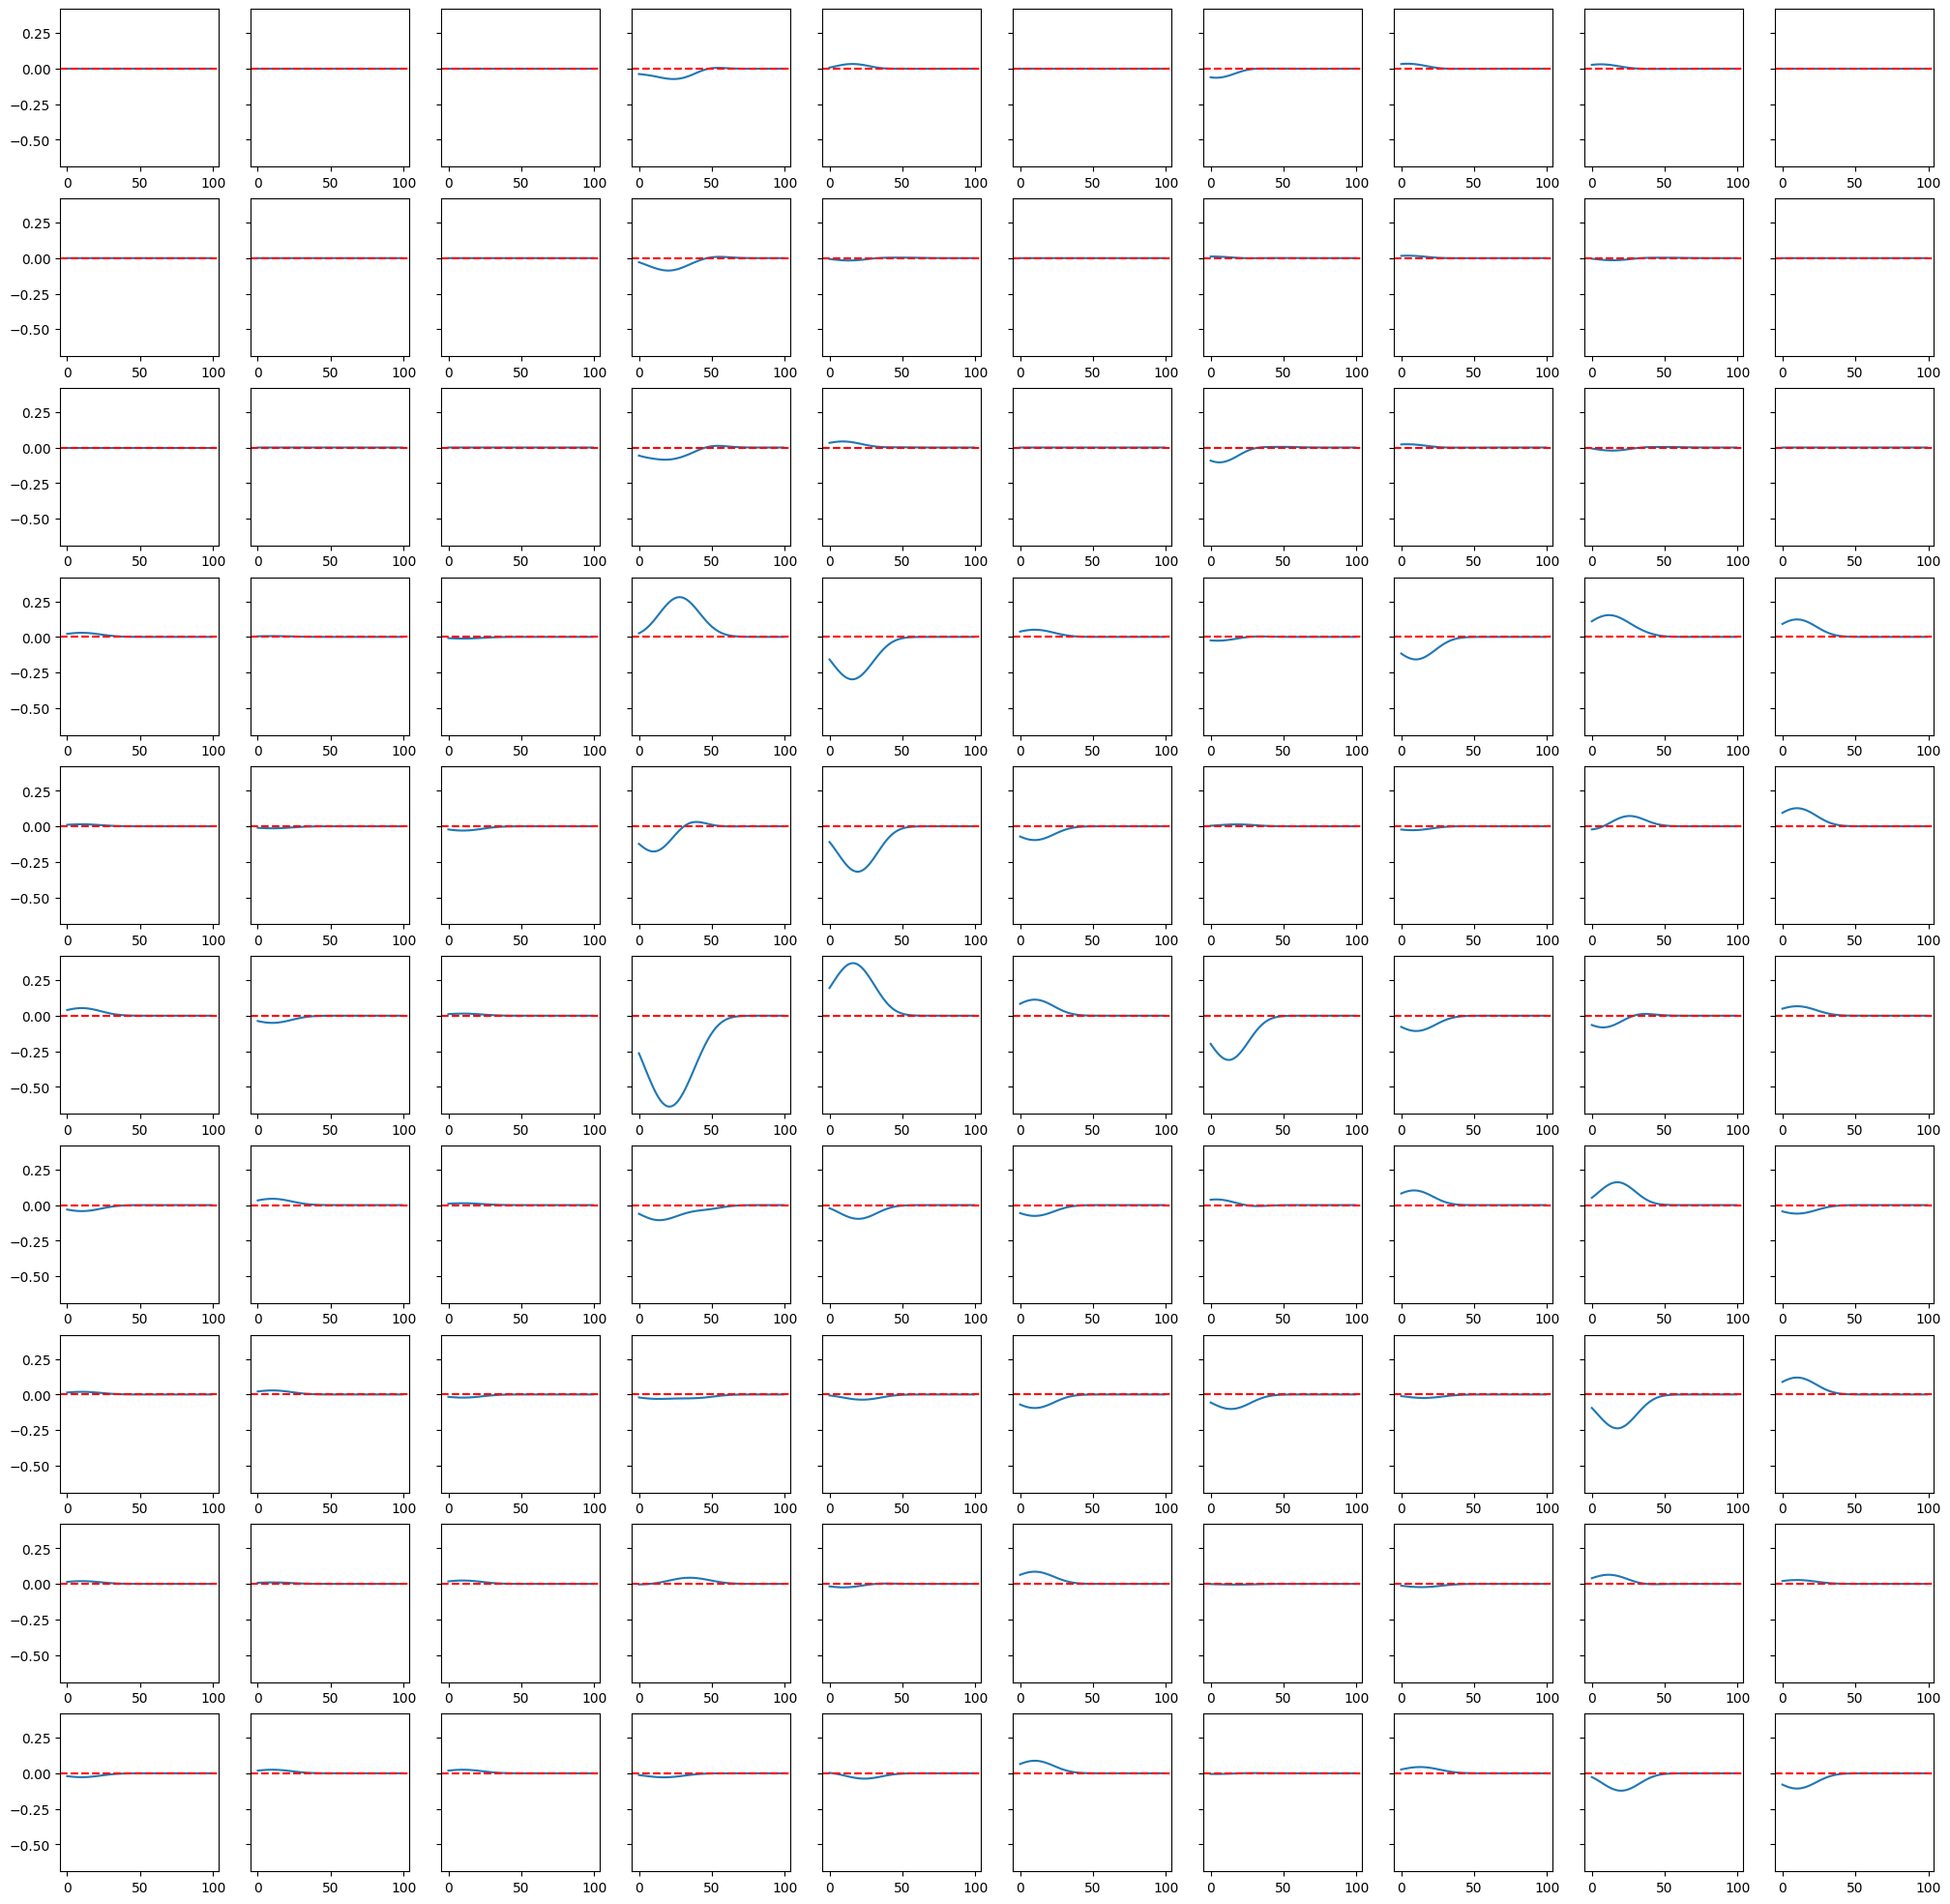

In [12]:
import matplotlib.pyplot as plt
weights =   params['deform_weights'].cpu().detach()
biases =    params['deform_biases'].cpu().detach()
stds =      params['deform_stds'].cpu().detach()

deforms = []
deformsx1 = []
for time in range(100):
    deform = torch.sum(weights*torch.exp(-1/(2*stds**2)*(time-biases)**2),1)
    deforms.append(deform) # Nx10 gaussians deformations
    deformsx1.append(deform[0,0])
fig,ax = plt.subplots(10,10,figsize = (25,25),sharey=True)
for i in range(10):
    for ii in range(10):
        ax[ii,i].plot([deforms[idx][i+91720//3,ii] for idx in range(len(deforms))])
        ax[ii,i].axhline(y = 0.0,color = 'r', linestyle = '--')    

In [9]:
torch.argmin(params['deform_stds'])

tensor(5635670, device='cuda:0')

In [10]:
params['deform_stds'].view(-1).shape

torch.Size([17362800])

In [11]:
maxs = np.array([deform.max() for deform in deforms])
maxs.max()

5.9373956

In [12]:
from GRN.models.conv_unet import GaussianRegressionNetwork
import torch

state_dict = torch.load('logs/GRN_6/checkpoint.pth',weights_only=False)
model_state_dict = state_dict['model']

model = GaussianRegressionNetwork()
model.load_state_dict(model_state_dict)

torch.save(model.state_dict(),'GRN/models/GRN_v1.pth')
